## Image Captioning

#### Used Resnet pretrained model to extract image features
#### Flickr 8K dataset for Model Building.This dataset has 8092 images with 5 captions for each image. I have used only 1000 images to train the model due to memory issue

In [2]:
import pandas as pd
import numpy as np
import cv2,os
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input,Dense,Embedding,LSTM,Dropout
from keras.layers.merge import add
from tensorflow.keras.utils import plot_model
from keras.models import Model

In [3]:
image_path="/content/Images/"
images=glob(image_path+ "*.jpg")

In [4]:
len(images)

8091

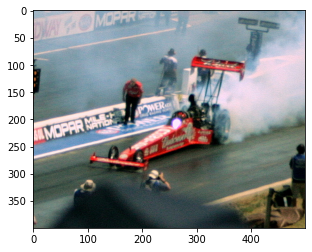

In [ ]:
img=cv2.imread(images[1])
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

#### Image Processing

In [5]:
#importing resnet model
image_model=ResNet50(include_top=True)

In [6]:
output=image_model.layers[-2].output  # excluding the last layer of the model
new_model=Model(inputs=image_model.input,outputs=output)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
#Giving all the images to the model and extracting features.
image_features={}
count=0
for i in images:
  img=cv2.imread(i)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(224,224))
  img=img.reshape(1,224,224,3)
  predictions=new_model.predict(img).reshape(2048,)

  img_name=i.split("/")[-1]
  image_features[img_name]=predictions
  count += 1

  if count > 999:       #Due to memory issue used only 1000 images 
    break
len(image_features)

1000

#### Caption Processing

In [ ]:
caption_path="/content/captions.txt"
caption=open(caption_path,'rb').read().decode('utf-8').split('\n')
caption

In [10]:
caption_dict={}
for i in caption:
  try:
    img_name=i.split(',')[0]
    captio=i.split(',')[1]
    if img_name in image_features:
      if img_name not in caption_dict:
        caption_dict[img_name]=[captio]
      else:
        caption_dict[img_name].append(captio)


  except:
    pass

# keeping only one unique image name with 5 captions as a list 

In [11]:
len(caption_dict)

1000

In [13]:
# Adding start and end tokens to each caption
for keys ,values in caption_dict.items():
  for i in values:
    caption_dict[keys][values.index(i)]='startofseq ' +i.lower()+' endofseq'

In [15]:
# Creating a vocabulary
count=1
count_words={}
for keys,values in caption_dict.items():
  for i in values:
    for word in i.split():
      if word not in count_words:
        count_words[word]=count
        count+=1

In [17]:
# Converting words to numbers for our model
for keys,values in caption_dict.items():
  for i in values:
    encoded=[]
    for word in i.split():
      encoded.append(count_words[word])

    caption_dict[keys][values.index(i)] =encoded

In [19]:
# Checking the maximum length of a caption in the given dataset
max_len=0
for keys,values in caption_dict.items():
  for i in values:
    if len(i)>max_len:
      max_len=len(i)

print(max_len)

34


In [21]:
Vocab=len(count_words)
Vocab=Vocab+1
Vocab

3234

#### Generating 3 lists which will be given to the model later

In [23]:
def generate(images , caption_dict):
  x_image=[]
  y_in=[]
  y_out=[]

  for keys,values in caption_dict.items():
    for i in values:
      for j in range(1,len(i)):
        x_image.append(images[keys])
        seq_in=[i[:j]]
        seq_out=i[j]

        seq_in=pad_sequences(seq_in,maxlen=max_len,padding='post',truncating='post')[0]
        seq_out=to_categorical([seq_out],num_classes=Vocab)[0]

        y_in.append(seq_in)
        y_out.append(seq_out)

  return x_image,y_in,y_out



In [24]:
x_image,y_in,y_out=generate(image_features,caption_dict)

In [25]:
len(x_image),len(y_in),len(y_out)

(61073, 61073, 61073)

In [26]:
#Converting lists to array
x_image=np.array(x_image)
y_in=np.array(y_in , dtype='float64')
y_out=np.array(y_out, dtype='float64')

In [28]:
x_image.shape,y_in.shape,y_out.shape

((61073, 2048), (61073, 34), (61073, 3234))

#### Model Building (CNN and LSTM)

In [30]:
input1=Input(shape=(2048,))
feature=Dropout(0.2)(input1) # to avoid overfitting
feature1=Dense(128, activation='relu')(feature)

input2=Input(shape=(max_len,))
seq=Embedding(Vocab , 128,mask_zero=True)(input2)
seq1=Dropout(0.2)(seq)
seq2=LSTM(128)(seq1)

decoder1=add([feature1,seq2])
decoder2=Dense(128,activation='relu')(decoder1)
output=Dense(Vocab,activation='softmax')(decoder2)

model=Model(inputs=[input1,input2],outputs=output)
model.compile(loss='categorical_crossentropy' , optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 128)      413952      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

#### Model Architecture

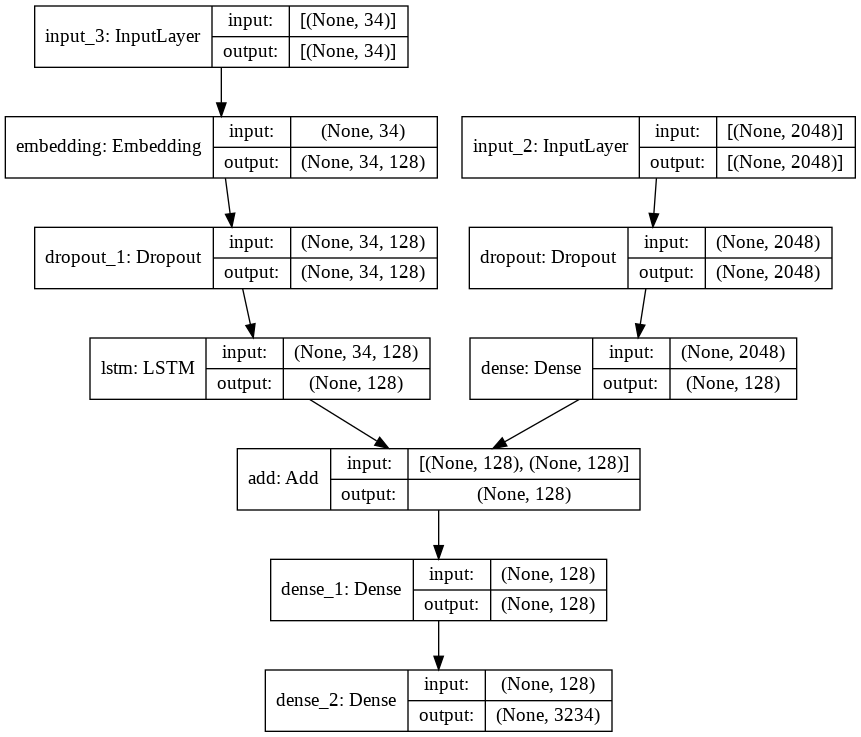

In [31]:
plot_model(model,to_file='model.png',show_shapes=True)

In [32]:
model.fit([x_image,y_in],y_out , batch_size=256,epochs=50)

Epoch 1/50
239/239 [==============================] - 12s 26ms/step - loss: 4.9335
Epoch 2/50
239/239 [==============================] - 6s 26ms/step - loss: 3.8225
Epoch 3/50
239/239 [==============================] - 6s 25ms/step - loss: 3.3128
Epoch 4/50
239/239 [==============================] - 6s 26ms/step - loss: 2.9636
Epoch 5/50
239/239 [==============================] - 6s 25ms/step - loss: 2.6922
Epoch 6/50
239/239 [==============================] - 6s 25ms/step - loss: 2.4780
Epoch 7/50
239/239 [==============================] - 6s 25ms/step - loss: 2.3053
Epoch 8/50
239/239 [==============================] - 6s 26ms/step - loss: 2.1713
Epoch 9/50
239/239 [==============================] - 6s 25ms/step - loss: 2.0587
Epoch 10/50
239/239 [==============================] - 6s 25ms/step - loss: 1.9655
Epoch 11/50
239/239 [==============================] - 6s 25ms/step - loss: 1.8826
Epoch 12/50
239/239 [==============================] - 6s 26ms/step - loss: 1.8078
Epoch 13/50


In [33]:
model.save('image_caption.h5')
model.save_weights('image_caption_weights.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#### Model Prediction using an image

In [34]:
images[4000]

'/content/Images/1433142189_cda8652603.jpg'

In [35]:
img=cv2.imread(images[4000])
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(224,224))
img=img.reshape(1,224,224,3)
predictions=new_model.predict(img).reshape(1,2048)

In [36]:
predictions

array([[2.230565  , 0.9132932 , 0.27074334, ..., 0.85624737, 0.        ,
        0.14266397]], dtype=float32)

In [37]:
# Inverse dictionary to map the numbers with predicted index and give words as an Output
text_input=['startofseq']
inverse_dict={v:k for k,v in count_words.items()}

In [41]:
count=0
while count <25:
  count+=1
  encoded=[]
  for i in text_input:
    encoded.append(count_words[i])

  encoded=[encoded]
  encoded=pad_sequences(encoded,maxlen=max_len,padding='post',truncating='post')
  pred=np.argmax(model.predict([predictions,encoded]))
  sample=inverse_dict[pred]

  if sample =='endofseq':
    break
  text_input.append(sample)


In [42]:
text_input

['startofseq',
 'a',
 'man',
 'is',
 'posing',
 'on',
 'a',
 'hill',
 'of',
 'snow',
 '.']

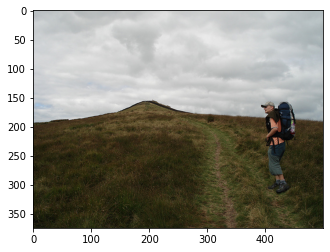

In [45]:
i=cv2.imread(images[4000])
i=cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
plt.imshow(i)